Загрузим все библиотеки

In [50]:
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import sklearn.metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
delivery = pd.read_csv('all_networks_episodes_delivery.csv', sep='|')
leadin = pd.read_csv('all_networks_episodes_leadin.csv', sep='|')

In [4]:
delivery.tail()

,PROGRAM_ID,SEASON,PROGRAM_DISTRIBUTOR,BROADCAST_DATE,PROGRAM_NAME,EPISODE_NAME,REPORTEDDURATION,DELIVERY
199188,104221068.0,14,POP,20180904,BIG BROTHER: AFTER DARK,BBA-180169 BBAD EP 1369 9/4/18,180,41
199189,104601130.0,1,ENT,20180909,ASHLEE & EVAN,101,60,282
199190,104870942.0,1,VICE,20180829,MISTER TACHYON,104 CAN MOTHER NATURE HEAL US,30,17
199191,104911071.0,3,DISC,20180831,BATTLEBOTS,NaN,61,270
199192,103990649.0,2,HGTV,20180810,TINY PARADISE,HTYPA-203H,30,395


В следующих ячейках все даты переформатируем в дни недели и сделаем из них фиктивные переменные (dummy). Также проверим динамику DELIVERY по годам.

In [102]:
BROADCAST_DATES = list(delivery.loc[:, 'BROADCAST_DATE'])

BROADCAST_YEAR = []
BROADCAST_DOW = []

for date in BROADCAST_DATES:
    d = [int(i) for i in         
            [
                str(date)[:4],
                str(int(str(date)[4:6])),
                str(int(str(date)[6:]))
            ]       
        ]
    
    BROADCAST_DOW.append(datetime.datetime(*d).weekday())
    BROADCAST_YEAR.append(
        
        int(datetime.datetime(*d).strftime('%Y'))
        
    )

In [103]:
dummies = pd.get_dummies(BROADCAST_DOW, drop_first=True)

dummies.columns = ['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']   # 0 0 0 0 0 0 - понедельник

dummies.index = delivery.index

In [104]:
new_delivery = pd.concat([delivery, dummies], axis=1)
new_delivery['YEAR'] = BROADCAST_YEAR
new_delivery.tail()

,PROGRAM_ID,SEASON,PROGRAM_DISTRIBUTOR,BROADCAST_DATE,PROGRAM_NAME,EPISODE_NAME,REPORTEDDURATION,DELIVERY,Tue,Wed,Thu,Fri,Sat,Sun,YEAR
199188,104221068.0,14,POP,20180904,BIG BROTHER: AFTER DARK,BBA-180169 BBAD EP 1369 9/4/18,180,41,1,0,0,0,0,0,2018
199189,104601130.0,1,ENT,20180909,ASHLEE & EVAN,101,60,282,0,0,0,0,0,1,2018
199190,104870942.0,1,VICE,20180829,MISTER TACHYON,104 CAN MOTHER NATURE HEAL US,30,17,0,1,0,0,0,0,2018
199191,104911071.0,3,DISC,20180831,BATTLEBOTS,NaN,61,270,0,0,0,1,0,0,2018
199192,103990649.0,2,HGTV,20180810,TINY PARADISE,HTYPA-203H,30,395,0,0,0,1,0,0,2018


In [99]:
new_delivery.groupby('YEAR').mean()['DELIVERY']

YEAR
2007    1372.316250
2008    1185.074722
2009    1178.341833
2010    1072.870213
2011     935.799093
2012     938.777390
2013     766.076483
2014     621.410960
2015     531.743032
2016     481.489760
2017     571.552642
2018     517.289184
Name: DELIVERY, dtype: float64

Очень хорошо видно, что DELIVERY постоянно спадал, начиная с 2007 года, и примерно с 2016 года усреднился в районе 500, значит имеет смысл добавить данную переменную.

In [105]:
dummies_year = pd.get_dummies(BROADCAST_YEAR, drop_first=True)

dummies_year.columns = ['2008', '2009', '2010', '2011', '2012', '2013',
                       '2014', '2015', '2016', '2017', '2018']

dummies_year.index = new_delivery.index

new_delivery = pd.concat([new_delivery, dummies_year], axis=1)

new_delivery.tail()

,PROGRAM_ID,SEASON,PROGRAM_DISTRIBUTOR,BROADCAST_DATE,PROGRAM_NAME,EPISODE_NAME,REPORTEDDURATION,DELIVERY,Tue,Wed,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
199188,104221068.0,14,POP,20180904,BIG BROTHER: AFTER DARK,BBA-180169 BBAD EP 1369 9/4/18,180,41,1,0,...,0,0,0,0,0,0,0,0,0,1
199189,104601130.0,1,ENT,20180909,ASHLEE & EVAN,101,60,282,0,0,...,0,0,0,0,0,0,0,0,0,1
199190,104870942.0,1,VICE,20180829,MISTER TACHYON,104 CAN MOTHER NATURE HEAL US,30,17,0,1,...,0,0,0,0,0,0,0,0,0,1
199191,104911071.0,3,DISC,20180831,BATTLEBOTS,NaN,61,270,0,0,...,0,0,0,0,0,0,0,0,0,1
199192,103990649.0,2,HGTV,20180810,TINY PARADISE,HTYPA-203H,30,395,0,0,...,0,0,0,0,0,0,0,0,0,1


Теперь ознакомимся со средним DELIVERY по всем телеканалам.

In [107]:
delivery_means_distributors = new_delivery.groupby(['PROGRAM_DISTRIBUTOR']).mean()['DELIVERY']

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(delivery_means_distributors.sort_values())

PROGRAM_DISTRIBUTOR
TR3S       11.923077
REY        13.185567
FUSE       14.998889
BEIE       15.000000
OVTN       15.930894
RFD        20.202128
GAC        22.260119
BHER       29.333333
CHIL       33.857143
SUND       35.319620
DLIF       36.183406
SMTH       36.187135
DFC        37.659574
HUB        40.769231
CNTRC      42.422535
ESQ        43.467772
STYL       46.500000
POP        50.327504
FS2        57.000000
CLOO       57.846154
DFH        57.893733
VICE       59.075824
TVGN       59.081174
CC         59.183550
IFC        61.892178
UP         66.031690
RLZC       68.193243
VS         69.583333
MTV2       74.928571
NBCSN      75.722222
AHC        76.782700
DIY        80.367358
LOGO       82.573437
MIL        84.117647
G4         84.325397
FYI        89.357066
TWC        94.436853
VEL       104.008723
MSNBC     107.562500
NGWD      107.801691
DSCI      108.228571
GSN       110.343284
DXD       121.290323
BBCA      121.927753
HLN       127.647059
DAM       130.050477
MAXP      136.

Чтобы не плодить огромное количество переменных по телеканалам, разобьем все телеканалы по группам. В каждой группе длина промежутка DELIVERY будет равна 50.

In [108]:
means = pd.DataFrame(delivery_means_distributors)

means['GROUP'] = pd.cut(delivery_means_distributors,
                       bins=list(range(10, 4100, 50)))

means['PROGRAM_DISTRIBUTOR'] = means.index
means.index = list(range(1, 113))

means = means.reindex(columns=['PROGRAM_DISTRIBUTOR', 'DELIVERY', 'GROUP'])

means['GROUP'] = means['GROUP'].cat.remove_unused_categories()

means

,PROGRAM_DISTRIBUTOR,DELIVERY,GROUP
1,ABC,2923.854757,"(2910, 2960]"
2,ADSM,515.712897,"(510, 560]"
3,AEN,777.306029,"(760, 810]"
4,AHC,76.782700,"(60, 110]"
5,AMC,1415.001742,"(1410, 1460]"
6,APL,294.618821,"(260, 310]"
7,BBCA,121.927753,"(110, 160]"
8,BEIE,15.000000,"(10, 60]"
9,BET,519.170136,"(510, 560]"
10,BHER,29.333333,"(10, 60]"


In [109]:
print(means['GROUP'].cat.categories.__len__())  # 25

25


В итоге мы получили 25 групп. Теперь разобьем наши телеканалы по этим группам.

In [110]:
groups = {}
for i in range(25):
    groups[i] = means[means['GROUP'] ==  means['GROUP'].cat.categories[i]]['PROGRAM_DISTRIBUTOR'].values

groups

{0: array(['BEIE', 'BHER', 'CC', 'CHIL', 'CLOO', 'CNTRC', 'DFC', 'DFH',
        'DLIF', 'ESQ', 'FS2', 'FUSE', 'GAC', 'HUB', 'OVTN', 'POP', 'REY',
        'RFD', 'SMTH', 'STYL', 'SUND', 'TR3S', 'TVGN', 'VICE'],
       dtype=object),
 1: array(['AHC', 'DIY', 'DSCI', 'FYI', 'G4', 'IFC', 'LOGO', 'MIL', 'MSNBC',
        'MTV2', 'NBCSN', 'NGWD', 'RLZC', 'TWC', 'UP', 'VEL', 'VS'],
       dtype=object),
 2: array(['BBCA', 'BOU', 'DAM', 'DXD', 'GSN', 'HLN', 'MAXP', 'SCI', 'TV1',
        'TVGC'], dtype=object),
 3: array(['CMT', 'CNBC', 'FXX', 'H2', 'LMN', 'OXYG', 'WGNA'], dtype=object),
 4: array(['DSNY', 'FRFM', 'FS1', 'ION', 'NAN', 'NGC', 'TRAV', 'WE'],
       dtype=object),
 5: array(['APL', 'CNN', 'HALL', 'PAR', 'STZP', 'WETV'], dtype=object),
 6: array(['ENT', 'OWN', 'SHO1', 'TOON', 'TVL'], dtype=object),
 7: array(['ID', 'NICK'], dtype=object),
 8: array(['CMDY', 'FAM', 'FOOD', 'HGTV', 'MTV', 'TRU'], dtype=object),
 9: array(['ADSM', 'BET', 'COURT', 'SPIKE', 'TLC'], dtype=object),
 10: ar

In [111]:
PROGRAM_DISTRIBUTOR_ARRAY = new_delivery['PROGRAM_DISTRIBUTOR']

PROGRAM_DISTRIBUTOR_CATEGORIZED = []
for pda in PROGRAM_DISTRIBUTOR_ARRAY:
    for cat in groups:
        if pda in groups[cat]:
            PROGRAM_DISTRIBUTOR_CATEGORIZED.append(cat)
            break

Теперь сделаем 24 фиктивных переменных на группы телеканалов, которые мы получили и назовем их.

In [112]:
# Group_0 is dropped due, so it equals all zeros values in dummies

PROGRAM_DISTRIBUTOR_DUMMY = pd.get_dummies(PROGRAM_DISTRIBUTOR_CATEGORIZED, drop_first=True)
PROGRAM_DISTRIBUTOR_DUMMY.columns = ['GROUP_1', 'GROUP_2', 'GROUP_3','GROUP_4','GROUP_5',
                                    'GROUP_6','GROUP_7','GROUP_8','GROUP_9','GROUP_10',
                                    'GROUP_11','GROUP_HBOM','GROUP_AEN','GROUP_FX','GROUP_15',
                                    'GROUP_TNT','GROUP_USA','GROUP_AMC','GROUP_PBS','GROUP_NBC',
                                    'GROUP_ABC','GROUP_FOX','GROUP_CBS','GROUP_ESPN']
PROGRAM_DISTRIBUTOR_DUMMY.index = new_delivery.index   # Для совпадения по индесам для дальнешего concat

In [113]:
new_delivery = pd.concat([new_delivery, PROGRAM_DISTRIBUTOR_DUMMY], axis=1) # Добавили наши фиктивныe
                                                                            # переменные в модель

Теперь рассмотим переменную SEASON. Для начала просто посмотрим на количество. И посмотрим на среднее DELIVERY по сезонам.

In [15]:
new_delivery['SEASON'].value_counts()

1          58112
2          27687
3          18316
4          13634
5           9723
6           6967
7           6088
8           3747
9           2883
11          2615
10          2491
Y           2213
12          2037
13          1760
14          1367
2011        1222
4Y          1114
3Y          1044
2013        1019
15           995
5Y           942
2009         869
2010         854
7Y           848
9Y           827
2008         812
2014         786
2012         776
2Y           773
8Y           695
           ...  
11BSP          1
S2BSP          1
xx             1
SP4            1
2ASP           1
m              1
XX             1
614Y           1
SP5            1
1sp            1
7ASP           1
13YY           1
12/13SP        1
D              1
7BSP           1
10y            1
SP2            1
30SP           1
SP1            1
1YSP           1
zz             1
A              1
2 SP           1
SP3            1
2BSP           1
110Y           1
y1             1
1ASP          

In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 5): 
    print(new_delivery.groupby(['SEASON']).mean()['DELIVERY'].sort_values(ascending=False))

SEASON
09/10      8855.696970
08/09      7529.424242
07/08      7108.666667
12/13SP    4652.000000
2 SP       4487.000000
34         4171.235294
35         3741.500000
37         3591.560000
38         3504.333333
42         3486.571429
39         3349.571429
36         3175.625000
43         2881.000000
41         2874.818182
33         2874.566667
40         2805.619048
DA3        2690.000000
44         2662.500000
54Y        2551.069519
15/16      2264.250000
16/17      2165.267016
55Y        2116.711628
14/15      2081.554404
17/18      2070.497175
1 SP       2065.666667
32         2056.140000
20         2037.232198
11/12      2005.592965
10/11      2004.289855
19         1967.389049
21         1963.735075
13/14      1957.760638
12/13      1956.382199
22         1948.419087
24         1895.525140
56Y        1885.728507
22Y        1848.814103
18         1787.134557
23         1771.865471
21Y        1768.285714
23Y        1659.185897
7A         1601.447368
26         1596.709677
57Y 

Поверхностно видно, что логики в DELIVERY по сезонам не имеется, и эти данные тяжело привести к нормальному виду (dummy), т.к. во-первых, очень большой разброс по количеству и также очень большой разброс по DELIVERY вприбавку к 200 с лишним разным значениям. Пока что эти данные использовать не будем.

### 80% выборки сделаем training, 20% test; Для этого вначале перемешаем таблицу.

In [144]:
np.random.seed(4)
# Shuffle
new_delivery_shuffled = new_delivery.sample(frac=1).reset_index(drop=True)

In [145]:
print(
    round(len(new_delivery) * 0.8), # Определим индекс разбивки
)

159334


In [146]:
training_delivery = new_delivery_shuffled.iloc[:159334, :]  
test_delivery = new_delivery_shuffled.iloc[159334:, :]    

In [147]:
X = sm.add_constant(
    training_delivery.drop(['SEASON', 'PROGRAM_ID', 'BROADCAST_DATE', 'PROGRAM_NAME',
                       'EPISODE_NAME', 'PROGRAM_DISTRIBUTOR', 'DELIVERY', 'YEAR'] ,axis=1)
)
y = pd.DataFrame(training_delivery['DELIVERY'])

X_test = sm.add_constant(
    test_delivery.drop(['SEASON', 'PROGRAM_ID', 'BROADCAST_DATE', 'PROGRAM_NAME',
                       'EPISODE_NAME', 'PROGRAM_DISTRIBUTOR', 'DELIVERY', 'YEAR'] ,axis=1)
)

y_test = pd.DataFrame(test_delivery['DELIVERY'])

## Начнем построение нашей модели с множественной линейной регрессии по всем признакам.

Определимся с метриками. Будем использовать две метрики прогноза для сравнения наших моделей - MAE и RMSE.

In [384]:
X = sm.add_constant(training_delivery.drop(['SEASON', 'PROGRAM_ID', 'BROADCAST_DATE', 'PROGRAM_NAME',
                       'EPISODE_NAME', 'PROGRAM_DISTRIBUTOR', 'DELIVERY', 'YEAR'] ,axis=1))
y = pd.DataFrame(training_delivery['DELIVERY'])

model = sm.OLS(y, X).fit()

predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               DELIVERY   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     5845.
Date:                Fri, 12 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:49:55   Log-Likelihood:            -1.2890e+06
No. Observations:              159334   AIC:                         2.578e+06
Df Residuals:                  159291   BIC:                         2.579e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              281.9438     12.407     22.724      0.000     257.626     306.261
REPORTEDDURATION     8.1952      0.096     85.474      0.000       8.007       8.383
Tue                -56.3524      6.950     -8.109      0.000     -69.973     -42.731
Wed                -36.6109      6.945     -5.272      0.000     -50.222     -23.000
Thu                -60.1990      7.109     -8.468      0.000     -74.132     -46.266
Fri               -288.4394      7.727    -37.331      0.000    -303.583    -273.295
Sat               -209.3112      8.844    -23.666      0.000    -226.646    -191.976
Sun                 36.1898      7.166      5.050      0.000      22.145      50.235
2008              -126.6950     11.863    -10.679      0.000    -149.947    -103.443
2009              -130.0215     11.732    -11.082      0.000    -153.016    -107.027
2010              -172.9723     11.458    -15.096      0.000    -195.429    -150.515
2011              -246.7481     11.023    -22.385      0.000    -268.353    -225.143
2012              -292.3486     11.180    -26.149      0.000    -314.262    -270.435
2013              -413.3190     10.842    -38.123      0.000    -434.568    -392.070
2014              -468.7410     10.614    -44.164      0.000    -489.543    -447.939
2015              -522.2039     10.584    -49.341      0.000    -542.947    -501.460
2016              -603.0265     10.618    -56.794      0.000    -623.837    -582.216
2017              -692.8850     11.059    -62.652      0.000    -714.561    -671.209
2018              -759.0241     11.763    -64.524      0.000    -782.080    -735.968
GROUP_1             30.2714     10.086      3.001      0.003      10.503      50.040
GROUP_2            -28.4219     12.105     -2.348      0.019     -52.148      -4.696
GROUP_3           -113.0738     12.700     -8.904      0.000    -137.965     -88.183
GROUP_4            -29.1129     10.966     -2.655      0.008     -50.606      -7.620
GROUP_5            182.8490     15.049     12.150      0.000     153.353     212.345
GROUP_6             52.0293      9.425      5.520      0.000      33.557      70.502
GROUP_7            176.9439     13.722     12.895      0.000     150.048     203.839
GROUP_8            320.6104      7.817     41.013      0.000     305.289     335.932
GROUP_9            333.2794     10.584     31.490      0.000     312.535     354.023
GROUP_10           285.5519     11.241     25.402      0.000     263.519     307.585
GROUP_11           444.1225     11.567     38.397      0.000     421.452     466.793
GROUP_HBOM         559.7451     19.187     29.174      0.000     522.140     597.350
GROUP_AEN          514.3095     14.731     34.914      0.000     485.437     543.182
GROUP_FX           520.8614     23.687     21.989      0.000     474.435     567.288
GROUP_15           630.

Из нашей модели видно, что все коэффициенты значимы при уровне альфа ~ 0.02, $R^2$ достаточно невелик, но приемлим. По тесту Дарбина-Уотсона авторегрессии первого порядка не имеется. Проверим наши переменные на мультиколлинеарность. 

In [135]:
vif_array = []
for i in range(42):       # 42 переменных в модели
    vif_array.append(vif(np.array(X), i))
[print(i) for i in vif_array];      # Видно, что только константа имеет большой VIF - R^2 около 0,974.

39.37402171974755
1.1683904639100082
1.718988578752824
1.7177664979081624
1.6770385764104998
1.553209943650429
1.436814319024663
1.7588046903950383
1.9649748287022246
2.0260486355886282
2.154407251674403
2.3748302047936742
2.3265629224866324
2.591300528974701
2.891545959482132
2.989720911143258
3.0175198077533567
2.470645513526845
2.116524131943868
1.3948124046661527
1.2598404345944068
1.2689525232696541
1.365132164555465
1.1630573950208352
1.690980260072983
1.193147477598705
2.1094710415292006
1.3925337396260473
1.366532279540911
1.308046455808272
1.1134745019977201
1.1837786941064838
1.0683058879409602
1.4397649626803741
1.0575101230518817
1.1094153406733283
1.055863945695778
1.0025312547660978
1.4825337715660887
1.2947958292819728
1.2246401902547677
1.2893032156849071


Проверим нашу модель на присутствие гетероскедастичности. Начнем с графического анализа.

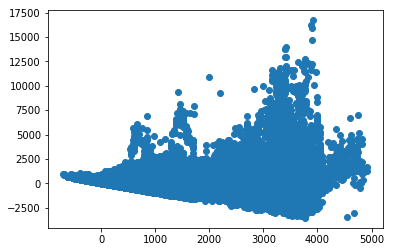

In [149]:
plt.scatter(y = model.resid, x = predictions);

На графике очень сильно видно, как в районе DELIVERY 3-4 тыс. разброс ошибок очень большой и ярко видна гетероскедастичность. Проверим наши наблюдения с помощью теста Бройша-Пагана.

In [126]:
print(statsmodels.stats.diagnostic.het_breuschpagan(model.resid, X))

(16195.842468963618, 0.0, 429.13117867964104, 0.0)


Второе и четвертые значение это p-value теста множителей Лагранжа и F-статистики, что дисперсия ошибки не зависит от наших независимых переменных. Так как они практически равны нулю, то мы можем отвергнуть нулевую гипотезу о том, что наши остатки гомоскедастичны при любом уровне значимости. Соответственно наша модель имеет гетероскедастичность, что, как видно из графика, при высоких DELIVERY разброс больше. Не будем углябляться в регрессии и строить по методу взвешенных наименьших квадратов (WLS), а перейдем к другим моделям, но для начала проверим нашу регрессию на тестовой выборке.

Посмотрим величину ошибок на тренировочной и тестовой выборках. 

In [150]:
RMSE = np.sqrt(sklearn.metrics.mean_squared_error(predictions, training_delivery['DELIVERY']))
MAE = sklearn.metrics.mean_absolute_error(predictions, training_delivery['DELIVERY'])
print(RMSE, MAE, sep='\n')

789.1509864149513
420.8119591079552


In [151]:
test_predictions = model.predict(  sm
                                 .add_constant(X_test)     )
MAE_TEST = sklearn.metrics.mean_absolute_error(test_predictions, y_test)
RMSE_TEST = np.sqrt(sklearn.metrics.mean_squared_error(test_predictions, y_test))

print('', 'MAE on test:', MAE_TEST, '\n', 'RMSE on test:', RMSE_TEST)    


 MAE on test: 419.793647046727 
 RMSE on test: 794.0692619751786


На тестовой выборке модель "отработала" практически индентично тренировочной, что неудивительно в случае линейной регрессии.

### Линейная регрессия без константы

In [414]:
X = training_delivery.drop(['SEASON', 'PROGRAM_ID', 'BROADCAST_DATE', 'PROGRAM_NAME',
                       'EPISODE_NAME', 'PROGRAM_DISTRIBUTOR', 'DELIVERY', 'YEAR'] ,axis=1)
y = pd.DataFrame(training_delivery['DELIVERY'])

model = sm.OLS(y, X).fit()

predictions = model.predict(X) 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               DELIVERY   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     9564.
Date:                Fri, 12 Apr 2019   Prob (F-statistic):               0.00
Time:                        15:14:39   Log-Likelihood:            -1.2893e+06
No. Observations:              159334   AIC:                         2.579e+06
Df Residuals:                  159292   BIC:                         2.579e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
REPORTEDDURATION     8.8951      0.091     97.807      0.000       8.717       9.073
Tue                -13.5264      6.700     -2.019      0.044     -26.658      -0.395
Wed                  9.9577      6.646      1.498      0.134      -3.069      22.984
Thu                -12.5996      6.804     -1.852      0.064     -25.936       0.737
Fri               -238.6815      7.422    -32.159      0.000    -253.228    -224.135
Sat               -159.2680      8.580    -18.563      0.000    -176.084    -142.452
Sun                 84.6521      6.852     12.354      0.000      71.222      98.082
2008                 8.1181     10.290      0.789      0.430     -12.050      28.287
2009                 5.7027     10.114      0.564      0.573     -14.121      25.527
2010               -35.1169      9.736     -3.607      0.000     -54.199     -16.035
2011              -106.8392      9.158    -11.666      0.000    -124.789     -88.889
2012              -151.4514      9.319    -16.253      0.000    -169.716    -133.187
2013              -267.0041      8.737    -30.561      0.000    -284.128    -249.880
2014              -314.0991      8.158    -38.502      0.000    -330.089    -298.109
2015              -364.7472      8.013    -45.520      0.000    -380.452    -349.042
2016              -444.2914      8.009    -55.471      0.000    -459.990    -428.593
2017              -549.4830      9.097    -60.404      0.000    -567.313    -531.653
2018              -616.3461      9.964    -61.859      0.000    -635.875    -596.817
GROUP_1             92.8912      9.718      9.559      0.000      73.844     111.938
GROUP_2             32.7119     11.821      2.767      0.006       9.542      55.882
GROUP_3            -55.2455     12.462     -4.433      0.000     -79.671     -30.820
GROUP_4             37.7786     10.580      3.571      0.000      17.041      58.516
GROUP_5            232.7464     14.912     15.608      0.000     203.519     261.974
GROUP_6            138.9107      8.629     16.099      0.000     121.999     155.823
GROUP_7            233.0592     13.520     17.238      0.000     206.560     259.558
GROUP_8            406.0771      6.864     59.159      0.000     392.624     419.531
GROUP_9            403.9176     10.133     39.860      0.000     384.056     423.779
GROUP_10           354.9612     10.836     32.758      0.000     333.723     376.200
GROUP_11           512.7465     11.183     45.849      0.000     490.827     534.666
GROUP_HBOM         628.8238     18.975     33.140      0.000     591.633     666.014
GROUP_AEN          589.7975     14.375     41.031      0.000     561.624     617.971
GROUP_FX           585.9657     23.552     24.880      0.000     539.805     632.126
GROUP_15           700.2998      9.929     70.534      0.000     680.840     719.760
GROUP_TNT          751.

Из нашей модели видно, что практически все коэффициенты значимы при уровне альфа ~ 0.01, кроме фиктивных переменных на 2008 и 2009 года, но убирать их не стоит, так как мы хорошо видили, что DELIVERY зависит от года и этих годов соответственно, вероятно что зависимость получилась не линейной, поэтому мы видим такие большие p-value. $R^2$ немного вырос. По тесту первого порядка Дарбина-Уотсона так же видно, что автокорреляции первого порядка не имеется. Проверим наши переменные на мультиколлинеарность.

In [138]:
vif_array = []
for i in range(42):       # 31 переменная в модели
    vif_array.append(vif(np.array(X), i))
[print(i) for i in vif_array];      # Видно, что мультколленеарности в нашей модели больше не имеется

5.9187063985131285
1.9119920598570115
1.8830516226977652
1.8085298641158152
1.6139519861262503
1.461556225580701
1.9067338395077569
1.5642327713452768
1.599001624129312
1.665229655268389
1.7825758507101972
1.7492420541040374
1.8539811844088452
1.9201248045958241
1.9375885384902953
1.9421306831025642
1.8239024141470583
1.6168508645048745
1.368474385610192
1.24082967763483
1.2579660408022681
1.3286131110193995
1.1621181279587511
1.5372089692761781
1.184620875340678
1.9318702851086225
1.34111332793908
1.3242224040464994
1.2694192215044988
1.0986737449996435
1.1486235592924932
1.06063293701527
1.391246273864304
1.0508009142261727
1.0969609799222797
1.0536896736203234
1.0025977175000356
1.4255359468354414
1.2646324289341186
1.1882194790565375
1.247088829558567
1.0618329919012914


In [140]:
RMSE = np.sqrt(sklearn.metrics.mean_squared_error(predictions, training_delivery['DELIVERY']))
MAE = sklearn.metrics.mean_absolute_error(predictions, training_delivery['DELIVERY'])
print(RMSE, MAE, sep='\n') # Видим, что в модели без константы метрики практические индентичны

790.4291128277694
421.4290882084107


In [141]:
test_predictions = model.predict(X_test)
MAE_TEST = sklearn.metrics.mean_absolute_error(test_predictions, y_test)
RMSE_TEST = np.sqrt(sklearn.metrics.mean_squared_error(test_predictions, y_test))

print('', 'MAE on test:', MAE_TEST, '\n', 'RMSE on test:', RMSE_TEST)


 MAE on test: 420.8363451498895 
 RMSE on test: 795.9316733818802


Видим, что разницы между моделей с константой и без практически нету по определенным нами метрикам.

### Regularization

Два раза в наших моделях при оценке summary, получался очень большой Condition number, что может также говорить о мультиколлениарности в нашей модели. Поэтому попробуем оценить нашу модель со штрафом - LASSO regression. Видно, что некоторые стандартные ошибки достаточно велики, поэтому имеет смысл строить данную регрессию.

In [257]:
X = training_delivery.drop(['SEASON', 'PROGRAM_ID', 'BROADCAST_DATE', 'PROGRAM_NAME',
                       'EPISODE_NAME', 'PROGRAM_DISTRIBUTOR', 'DELIVERY', 'YEAR'] ,axis=1)
y = pd.DataFrame(training_delivery['DELIVERY'])

model = sm.OLS(y, X).fit_regularized(alpha=0.1, L1_wt=1)

predictions = model.predict(X) 


In [143]:
RMSE = np.sqrt(sklearn.metrics.mean_squared_error(predictions, training_delivery['DELIVERY']))
MAE = sklearn.metrics.mean_absolute_error(predictions, training_delivery['DELIVERY'])
print(RMSE, MAE, sep='\n')

794.4165306674482
420.55086341385334


Так мы не знаем, какие параметры регуляризации подобрать, то попробуем методом подбора оптимизировать по MAE. Попробуем использовать LASSO. 

$alpha = 0,001 ... 1$. В каждом интервале: $0.001 - 0.01;  0.01 - 0.1;  0.1 - 1$  у нас задача сделать равновероятные шансы попасть в промежутки между этими интервалами.

In [258]:
np.random.seed(4)
alpha_array = []
for i in range(50):
    r = -3 * np.random.rand() 
    alpha_array.append(10 ** r)
    

In [259]:
MAE_ON_ALPHAS = []
for alpha in alpha_array:
    model = sm.OLS(y, X).fit_regularized(alpha=alpha, L1_wt=1)  # L1_wt - LASSO
    predictions = model.predict(X) 
    MAE = sklearn.metrics.mean_absolute_error(predictions, training_delivery['DELIVERY'])
    RMSE = np.sqrt(sklearn.metrics.mean_squared_error(predictions, training_delivery['DELIVERY']))
    MAE_ON_ALPHAS.append([alpha, MAE, RMSE])

In [260]:
sorted(MAE_ON_ALPHAS, key=lambda x: x[2]) # Видно, что регуляризация не сильно меняет порядок вещей, значит 
                                          # с мультиколлинеарностью у нас в модели все впорядке.

[[0.0011214966185610674, 421.4778709239722, 790.4292182635605],
 [0.0011780850252616057, 421.47729920394937, 790.429219560114],
 [0.0012076662239440161, 421.4770003454622, 790.42922026237],
 [0.001255771096719633, 421.4765143499926, 790.4292214402843],
 [0.0013490905396550041, 421.47557155929724, 790.4292238521476],
 [0.0014225517677215278, 421.4748294318036, 790.4292258684917],
 [0.001539165244628509, 421.4736514827421, 790.4292292822389],
 [0.0025184428744570928, 421.4637625444663, 790.4292682611726],
 [0.002576441543123499, 421.46317700959986, 790.4292711477832],
 [0.004376047648879291, 421.44502679906617, 790.429392835057],
 [0.004590407438142642, 421.44286696640347, 790.4294114778753],
 [0.00498637686283714, 421.43887735462863, 790.4294482373076],
 [0.006307532507848316, 421.42557605886225, 790.4295926829153],
 [0.007170542578484091, 421.41698653213933, 790.429705149534],
 [0.008068885007127864, 421.4080584600364, 790.4298374239014],
 [0.008709611036828813, 421.4016965826635, 790.

### Построим теперь дерево, и посмотрим его прогнозы

Построим модель случайного леса, перед этим оптимизируя параметры с помощью GridSearch.

In [154]:
X_tree = X
y_tree = np.ravel(y)

In [155]:
beg = time.perf_counter()

gsc = GridSearchCV(
        estimator=RandomForestRegressor(criterion='mse'),
        param_grid={
        'max_depth': range(10, 30),
        'n_estimators': (10, 100),
        },
        cv=3, verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_tree, y_tree)
best_params = grid_result.best_params_    # max_depth = 27, n_estimators = 100
    
print(time.perf_counter() - beg)      # 1400 секунд


1369.2766245439998


In [156]:
best_params

{'max_depth': 27, 'n_estimators': 100}

Теперь оценим наши метрики по только что найденным оптимальным параметрам.

In [162]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=27, criterion='mse').fit(X_tree, y_tree)

predictions_tree = rfr.predict(sm.add_constant(X_test))          # Проверяем на тестовой выборке

MAE_TEST = sklearn.metrics.mean_absolute_error(predictions_tree, y_test)
RMSE_TEST = np.sqrt(sklearn.metrics.mean_squared_error(predictions_tree, y_test))
print('MAE on random forest model:',MAE_TEST, '\n'
      'RMSE on random forest model:', RMSE_TEST)   

MAE on random forest model: 213.00827749047048 
RMSE on random forest model: 484.18122728966335


Мы видим, что точность прогноза сильно (почти в два раза) увеличилась по сравнению с линейной регрессией. Попробуем слегка модифицировать наши признаки и заново построить модель случайного леса. Так как мы уже работаем с деревом, то можно пронумеровать признак PROGRAM_DISTRIBUTOR в алфавитном порядке (Label Encoding).

In [164]:
le = LabelEncoder()

le.fit(training_delivery['PROGRAM_DISTRIBUTOR'])

distr_label_train = le.transform(training_delivery['PROGRAM_DISTRIBUTOR'])  # Вначале сортирует по алфавиту,
                                                                            # а потом присваивает лейбл
                                                                            # соотв. каналу по индексу
        
distr_label_test = le.transform(test_delivery['PROGRAM_DISTRIBUTOR'])

In [184]:
X_new_tree = sm.add_constant(
    
    training_delivery.loc[:, ['REPORTEDDURATION', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'YEAR']]
    
)

X_new_tree['PROGRAM_DISTRIBUTOR_LABELED'] = distr_label_train

X_test_tree = sm.add_constant(
    
    test_delivery.loc[:, ['REPORTEDDURATION', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'YEAR'] ]
    
)

X_test_tree['PROGRAM_DISTRIBUTOR_LABELED'] = distr_label_test

In [188]:
beg = time.perf_counter()

gsc = GridSearchCV(
        estimator=RandomForestRegressor(criterion='mse'),
        param_grid={
            
        'max_depth': range(10, 30),
        'n_estimators': (10, 100, 200),
        
        },
        cv=4, verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X_new_tree, y_tree)
best_params = grid_result.best_params_   

print(time.perf_counter() - beg)  # 2600 секунд

/home/evgen/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/evgen/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/evgen/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/evgen/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/

2590.1353794050083


In [190]:
print(best_params)  # max_depth = 20, n_estimators = 100

{'max_depth': 20, 'n_estimators': 100}


In [ ]:
# predictions_tree = gsc.predict(X_test_tree)

# MAE_TEST = sklearn.metrics.mean_absolute_error(predictions_tree, y_test)
# RMSE_TEST = np.sqrt(sklearn.metrics.mean_squared_error(predictions_tree, y_test))
# print('MAE on random forest model:',MAE_TEST, '\n'
#      'RMSE on random forest model:', RMSE_TEST)

In [191]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=20,
                            criterion='mse').fit(X_new_tree, y_tree)

predictions_tree = rfr.predict(X_test_tree)

MAE_TEST = sklearn.metrics.mean_absolute_error(predictions_tree, y_test)
RMSE_TEST = np.sqrt(sklearn.metrics.mean_squared_error(predictions_tree, y_test))
print('MAE on random forest model:',MAE_TEST, '\n'
      'RMSE on random forest model:', RMSE_TEST)

MAE on random forest model: 191.57369826690118 
RMSE on random forest model: 452.86787879143856


Видно, что алгоритм случайного леса на немного модифицированных данных намного лучше "отработал" на тестовой выборке, чем линейная регрессия. И дисперсия значительно снизилась. Проанализируем ошибки и сравним наши модели по метрикам.

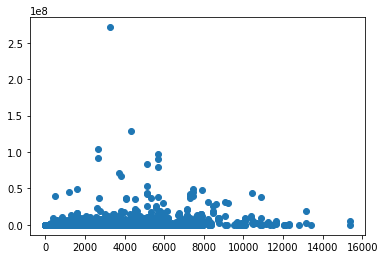

In [205]:
errors = (predictions_tree - np.ravel(y_test))**2
plt.scatter(predictions_tree, errors);

Из графика выше видно, что разброс по ошибкам стал намного более приемлим, несмотря на некоторые довольно больше выбросы, которые можно убрать из нашей модели.

### Попробуем спогнозировать CLEAR DELIVERY как если бы там дали данные по некоторым сериалам - RIDE WITH NORMAN REEDUS.

Допустим, RIDE WITH NORMAN REEDUS идет через год и немного изменим даты. REPORTED DURATION каждой серии равняется 60. LEADIN DELIVERY LIVE для всех эпизодов - 300, LEADIN CONTRIBUTION - 90. Также мы знаем, что будет показываться второй сезон, но в наших моделях мы данную переменную не вводили. Допустим наш сериал будет показывать тот же телеканал.

In [239]:
delivery[delivery.loc[:, 'PROGRAM_NAME'] == 'RIDE WITH NORMAN REEDUS'].sort_values('BROADCAST_DATE')

,PROGRAM_ID,SEASON,PROGRAM_DISTRIBUTOR,BROADCAST_DATE,PROGRAM_NAME,EPISODE_NAME,REPORTEDDURATION,DELIVERY
123380,83512096.0,1,AMC,20160612,RIDE WITH NORMAN REEDUS,101 CALIFORNIA: PACIFIC COAST HIGHWAY,60,388
191410,85082200.0,1,AMC,20160619,RIDE WITH NORMAN REEDUS,102 DEATH VALLEY DANTES VIEW,60,266
114636,84932363.0,1,AMC,20160626,RIDE WITH NORMAN REEDUS,103 APPALACHIA: BLUE RIDGE PARKWAY,60,281
98414,86740033.0,1,AMC,20160703,RIDE WITH NORMAN REEDUS,104 TEXAS: TWISTED SISTERS,60,295
72273,86900153.0,1,AMC,20160710,RIDE WITH NORMAN REEDUS,105 LOUISIANA: CRESCENT CITY,60,303
51482,85540249.0,1,AMC,20160717,RIDE WITH NORMAN REEDUS,106 THE KEYS WITH PETER FONDA,60,303


In [352]:
x1 = delivery[delivery.loc[:, 'PROGRAM_ID'] == 83512096.0].copy()

x1['BROADCAST_DATE'] = 20170612
x1['EPISODE_NAME'] = 'Any'
x1['SEASON'] = 2

x1 = x1.drop('DELIVERY', axis=1)

x2, x3, x4, x5, x6 = x1.copy(), x1.copy(), x1.copy(), x1.copy(), x1.copy()

x2['BROADCAST_DATE'] = 20170615

x3['BROADCAST_DATE'] = 20170617
x3['REPORTEDDURATION'] = 70

x4['BROADCAST_DATE'] = 20170626

x5['BROADCAST_DATE'] = 20170704
x5['REPORTEDDURATION'] = 50

x6['BROADCAST_DATE'] = 20170710

x_ride_with = x1.append([x2, x3, x4, x5, x6])

In [353]:
x_ride_with   # Искуственные данные

,PROGRAM_ID,SEASON,PROGRAM_DISTRIBUTOR,BROADCAST_DATE,PROGRAM_NAME,EPISODE_NAME,REPORTEDDURATION
123380,83512096.0,2,AMC,20170612,RIDE WITH NORMAN REEDUS,Any,60
123380,83512096.0,2,AMC,20170615,RIDE WITH NORMAN REEDUS,Any,60
123380,83512096.0,2,AMC,20170617,RIDE WITH NORMAN REEDUS,Any,70
123380,83512096.0,2,AMC,20170626,RIDE WITH NORMAN REEDUS,Any,60
123380,83512096.0,2,AMC,20170704,RIDE WITH NORMAN REEDUS,Any,50
123380,83512096.0,2,AMC,20170710,RIDE WITH NORMAN REEDUS,Any,60


Ниже напишем функцию, на вход которой будет подаваться таблица в формате как выше, а на выходе таблица в формате, который требуется для того, чтобы подавать на вход в наших моделях.

In [354]:
# Напишем функцию для обработки input для прогнозирования в наших моделях

def modify(df, dummy=True):
    
    def day_to_dummy(day):
        a = np.zeros(6)
        if day != 0:
            a[day - 1] = 1
        return a.reshape(1, 6)
    
    def year_to_dummy(year):
        a = np.zeros(11)
        year -= 2008
        a[year] = 1
        return a.reshape(1, 11)
    
    def dist_to_dummy(distr):
        a = np.zeros(24)
        if distr != 0:
            a[distr - 1] = 1
        return a.reshape(1, 24)
        
        
    BROADCAST_DATES = list(df.loc[:, 'BROADCAST_DATE'])

    BROADCAST_YEAR = []
    BROADCAST_DOW = []

    for date in BROADCAST_DATES:
        d = [int(i) for i in 
             
                [
                    str(date)[:4],
                    str(int(str(date)[4:6])),
                    str(int(str(date)[6:]))
                ]        
            ]
        
        BROADCAST_DOW.append(datetime.datetime(*d).weekday())
        BROADCAST_YEAR.append(
        
        int(datetime.datetime(*d).strftime('%Y'))
        
        )
     
    dummy_days = np.array([])
    for day in BROADCAST_DOW:
        dummy_days = np.append(dummy_days, day_to_dummy(day))
        
    dummy_days = dummy_days.reshape(len(df), 6)
    
    dummy_year = np.array([])    
    for year in BROADCAST_YEAR:
        dummy_year = np.append(dummy_year, year_to_dummy(year))
    
    dummy_year = dummy_year.reshape(len(df), 11)
    
    dummy_days = pd.DataFrame(dummy_days)
    dummy_days.columns = ['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    dummy_days.index = df.index
    
    dummy_year = pd.DataFrame(dummy_year)
    dummy_year.columns = ['2008', '2009', '2010', '2011', '2012', '2013',
                       '2014', '2015', '2016', '2017', '2018']
    dummy_year.index = df.index
    
    
    PROGRAM_DISTRIBUTOR_ARRAY = df['PROGRAM_DISTRIBUTOR']
    PROGRAM_DISTRIBUTOR_CATEGORIZED = []
    
    for pda in PROGRAM_DISTRIBUTOR_ARRAY:
        for cat in groups:
            if pda in groups[cat]:
                PROGRAM_DISTRIBUTOR_CATEGORIZED.append(cat)
                break
    
    dummy_program = np.array([])
    for dist in PROGRAM_DISTRIBUTOR_CATEGORIZED:
        dummy_program = np.append(dummy_program, dist_to_dummy(dist))
        
    dummy_program = dummy_program.reshape(len(df), 24)

    dummy_program = pd.DataFrame(dummy_program)   
    
    dummy_program.columns = ['GROUP_1', 'GROUP_2', 'GROUP_3','GROUP_4','GROUP_5',
                             'GROUP_6','GROUP_7','GROUP_8','GROUP_9','GROUP_10',
                             'GROUP_11','GROUP_HBOM','GROUP_AEN','GROUP_FX','GROUP_15',
                             'GROUP_TNT','GROUP_USA','GROUP_AMC','GROUP_PBS','GROUP_NBC',
                             'GROUP_ABC','GROUP_FOX','GROUP_CBS','GROUP_ESPN']
    
    dummy_program.index = df.index
    
    
    
    
    new_df = pd.concat([df, dummy_days, dummy_year, dummy_program], axis=1)
    new_df['YEAR'] = BROADCAST_YEAR
    
    PROGRAM_DISTRIBUTOR_LABELED = le.transform(list(df.loc[:, 'PROGRAM_DISTRIBUTOR']))
    new_df['PROGRAM_DISTRIBUTOR_LABELED'] = PROGRAM_DISTRIBUTOR_LABELED
    
    new_df.index = list(range(len(df)))
    
    return new_df


Проверим правильность написанной функции

In [355]:
X_for_forecast = modify(x_ride_with) # Теперь можем вставлять в модель
X_for_forecast

,PROGRAM_ID,SEASON,PROGRAM_DISTRIBUTOR,BROADCAST_DATE,PROGRAM_NAME,EPISODE_NAME,REPORTEDDURATION,Tue,Wed,Thu,...,GROUP_USA,GROUP_AMC,GROUP_PBS,GROUP_NBC,GROUP_ABC,GROUP_FOX,GROUP_CBS,GROUP_ESPN,YEAR,PROGRAM_DISTRIBUTOR_LABELED
0,83512096.0,2,AMC,20170612,RIDE WITH NORMAN REEDUS,Any,60,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,4
1,83512096.0,2,AMC,20170615,RIDE WITH NORMAN REEDUS,Any,60,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,4
2,83512096.0,2,AMC,20170617,RIDE WITH NORMAN REEDUS,Any,70,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,4
3,83512096.0,2,AMC,20170626,RIDE WITH NORMAN REEDUS,Any,60,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,4
4,83512096.0,2,AMC,20170704,RIDE WITH NORMAN REEDUS,Any,50,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,4
5,83512096.0,2,AMC,20170710,RIDE WITH NORMAN REEDUS,Any,60,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,4


Сделаем прогноз.

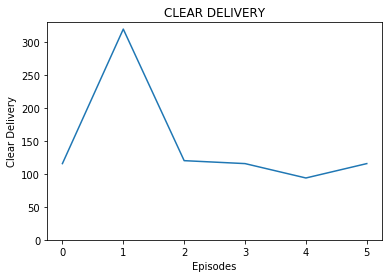

In [382]:
delivery_predict = rfr.predict(
    
    sm.add_constant(
        
        X_for_forecast.loc[
        
        :, [
            'REPORTEDDURATION', 'Tue', 'Wed',
            'Thu', 'Fri', 'Sat', 'Sun',
            'YEAR', 'PROGRAM_DISTRIBUTOR_LABELED', 
           ]     
       ]
        
        , has_constant='add'
        
    )
  )

clear_delivery = delivery_predict - 90

fig = plt.figure()
ax = fig.subplots(1)
ax.plot(clear_delivery)
ax.set_title('CLEAR DELIVERY')
ax.set_ylim(0, 330);
ax.set_xlabel('Episodes')
ax.set_ylabel('Clear Delivery');

Выше график предсказаний CLEAR_DELIVERY по шести сериям по модели случайного леса. Теперь попробуем спрогнозировать по построенной линейной регрессии. 

In [416]:
X_for_forecast = modify(x_ride_with).drop(
    
    [ 
        'PROGRAM_ID', 'SEASON', 'PROGRAM_DISTRIBUTOR',
        'BROADCAST_DATE', 'PROGRAM_NAME', 'EPISODE_NAME',
        'YEAR', 'PROGRAM_DISTRIBUTOR_LABELED'
    ],  
    axis=1
)

#X_for_forecast = sm.add_constant(X_for_forecast, has_constant='add')

In [417]:
delivery_predict = model.predict(X_for_forecast)

In [419]:
clear_delivery = delivery_predict - 90
clear_delivery

0    1117.350524
1    1104.750945
2    1047.033143
3    1117.350524
4    1014.873478
5    1117.350524
dtype: float64

Видим, что линейная модель спрогнозировала DELIVERY намного выше, чем дерево. Как мы видили, в линейной модели присутствует высокое непостоянство дисперсии остатков, а так же RMSE и MAE намного выше, чем у построенного дерева. Также, вероятно, что завивимости являются нелинейными, например, как мы видили, в случае DELIVERY по годам. Поэтому, конечно, стоит отдать предпочтение модели случайного леса в данном случае, у которого, как мы еще видели, с непостоянством остатков все намного лучше.

### Заключение


В данной работе были постороены разные модели - обычные линейные регрессии с константой и без, регрессия со штрафом (LASSO в нашем случае), два немного разных дерева, из которых мы выбрали последнее ввиду лучших метрик MAE и RMSE, от которых мы и отталикиваемся. В итоге оптимизированное по гиперпараметрам дерево дало хороший результат на тестовых данных, что говорит в его пользу при прогнозе в данном конкретном случае.